In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm

import random
from scipy import ndarray
import skimage as sk
from skimage import transform, util

In [2]:
# global variables
DATA_DIR = '/home/bryan/Desktop/projectsML/classifySon/bryanVyiwen'
TRAIN_DIR = DATA_DIR
TEST_DIR = DATA_DIR + '/leonPhotos/croppedFaces'
IMG_SIZE = 50 # image size (square)
LR = 1e-3 # learning rate

CAT1 = 'bryan' # name of first category
CAT2 = 'yiwen' # name of second category

MODEL_NAME = 'bryanVyiwen{}_{}.model'.format(LR, 'reducedClarifai-8covNet')
TRAIN_FILE = 'allFacesBryanYiwenAugmentedOrdered.npy'

In [3]:
def label_img(img):
    word_label = img.split('.')[-3] # format = name.number.jpg
    if word_label == CAT1: return [1, 0]
    elif word_label == CAT2: return [0, 1]

def read_preprocessed_npdata(fileDir, fileName):
    fullName = fileDir + '/' + fileName
    if(os.path.exists(fileDir)):
        if(os.path.isfile(fullName)):
            npData = np.load(fullName)
        else:
            print('File' + fileName + 'does not exist!')
    else:
        print('Path' + fileDir + 'does not exist!')
    return npData
        
def create_train_data():
    training_data = [] # instantiate empty list
    for img in tqdm(os.listdir(TRAIN_DIR)): # if tqdm not available, replace tqdm(A) w/ A
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data) # randomly shuffle the images
    np.save('train_data.npy', training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0] # format = number.jpg
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data

def read_raw_data(file_dir):
    raw_data = [] # instantiate empty list
    for img in tqdm(os.listdir(file_dir)): # if tqdm not available, replace tqdm(A) w/ A
        label = label_img(img)
        path = os.path.join(file_dir, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        raw_data.append([np.array(img), np.array(label)])
    shuffle(raw_data) # randomly shuffle the images
#     np.save('train_data.npy', training_data)
    return raw_data

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between X% on the left and X% on the right
    random_degree = random.uniform(-45, 45)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

In [4]:
train_data = read_preprocessed_npdata(TRAIN_DIR, TRAIN_FILE)
np.random.seed(13)
randomIndx = np.random.permutation(train_data.shape[0])
train_data = train_data[randomIndx, :]

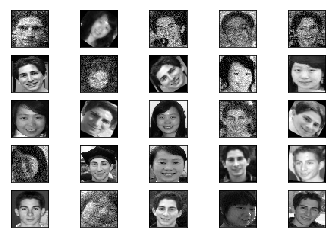

In [5]:
fig = plt.figure()
iN = 100
for i in range(25):
    y = fig.add_subplot(5, 5, i + 1)
#     y.imshow(aug_data[iN - 1 + i * numImages][0], cmap='gray')
    y.imshow(train_data[i][0], cmap='gray')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
#     print(train_data[i][1])

In [6]:
# raw_data = read_raw_data(DATA_DIR)

In [7]:
# # let's do some brief bookkeeping
# # this dictionary summarizes the possible transformation
# available_transformations = {
#     'rotate': random_rotation,
#     'noise': random_noise,
#     'horizontal_flip': horizontal_flip
# }

In [8]:
# # augment data
# aug_data = raw_data.copy()
# choices = list(available_transformations)
# for i in range(len(available_transformations)): # for each transformation
#     for j in range(len(raw_data)): # for each image
#         transformed_image = available_transformations[choices[i]](raw_data[j][0])
#         aug_data.append([np.array(transformed_image), np.array(raw_data[j][1])])

In [9]:
# fig = plt.figure()
# iN = 100
# numImages = len(raw_data)
# for i in range(4):
#     y = fig.add_subplot(2, 2, i + 1)
#     y.imshow(aug_data[iN - 1 + i * numImages][0], cmap='gray')
#     y.axes.get_xaxis().set_visible(False)
#     y.axes.get_yaxis().set_visible(False)

In [10]:
import tflearn
import tensorflow as tf
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [11]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='x') # input layer

# this is scaled-down version of Clarifai, ILSVRC's 2013 winner (Zeiler and Fergus, 2014)
# * The number of conv. filters is downsampled by 2x in all layers but layer 1
# * The number of conv. filters in layer 1 is 46 (compared to 96)

# layer 1, convolutional
convnet = conv_2d(convnet, 46, 7, strides=2, activation='relu', name='conv1') # 96 => 46
convnet = max_pool_2d(convnet, 3, strides=2, name='pool1')

# layer 2, convolutional
convnet = conv_2d(convnet, 128, 5, strides=2, activation='relu', name='conv2') # 256 => 128
convnet = max_pool_2d(convnet, 3, strides=2, name='pool2')

# layer 3, convolutional
convnet = conv_2d(convnet, 192, 3, activation='relu', name='conv3') # 384 => 192

# layer 4, convolutional
convnet = conv_2d(convnet, 192, 3, activation='relu', name='conv4') # 384 => 192
convnet = max_pool_2d(convnet, 3, strides=2, name='pool4')

# layer 5, convolutional
convnet = conv_2d(convnet, 128, 1, activation='relu', name='conv2') # 256 => 128

# layer 6, fully connected
convnet = fully_connected(convnet, 2048, activation='relu', name='fc6') # 4096 => 2048
convnet = dropout(convnet, 0.5)

# layer 7, fully connected
convnet = fully_connected(convnet, 2048, activation='relu', name='fc7') # 4096 => 2048
convnet = dropout(convnet, 0.5)

# layer 8, fully connected, output
convnet = fully_connected(convnet, 2, activation='softmax', name='fc8')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='y')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
numImages = train_data.shape[0]
numTest = int(0.05 * numImages)

In [13]:
train = train_data[:-numTest] # all but last 'numTest' images
test = train_data[-numTest:] # last 'numTest' images

In [14]:
# extract training data from above lists
# recall: first element is image, second element is classification
X = np.array([i[0] for i in train], dtype='float').reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train], dtype='float')

# extract test data from above lists
test_x = np.array([i[0] for i in test], dtype='float').reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = np.array([i[1] for i in test], dtype='float')

In [15]:
# the model was already fitted, so let's load it
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model Loaded!')
    
# here is where we fit the model
# model.fit({'x': X}, {'y': Y}, n_epoch=20, validation_set=({'x': test_x}, {'y': test_y}), \
#           snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

INFO:tensorflow:Restoring parameters from /home/bryan/Desktop/projectsML/classifySon/bryanVyiwen0.001_reducedClarifai-8covNet.model
Model Loaded!


In [16]:
# tensorboard --logdir=/home/bryan/Desktop/kaggleData/log
# tf.reset_default_graph() # reset graph w/o having to restart kernal

In [17]:
# save the model if you're happy with the results
# model.save(MODEL_NAME)

In [18]:
test_data = read_raw_data(TEST_DIR) # let's load pictures of my son to test

100%|██████████| 14/14 [00:00<00:00, 180.81it/s]


8 6


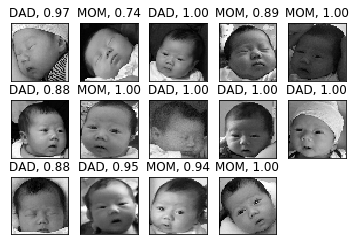

In [19]:
cntMom = 0
cntDad = 0
fig = plt.figure()
for i in range(len(test_data)):
    img_data = test_data[i][0]
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    y = fig.add_subplot(3, 5, i + 1)
    y.imshow(img_data, cmap='gray')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)    
    model_out = model.predict([data])[0]
    
    tmp = round(model_out.max(), 2)
    if(model_out[0] > model_out[1]):
        cntDad += 1
        plt.title('DAD, ' + "{0:.2f}".format(tmp))
    else:
        cntMom += 1
        plt.title('MOM, ' + "{0:.2f}".format(tmp))
print(cntDad, cntMom)